<a href="https://colab.research.google.com/github/Yashmaini30/Breast-Cancer-Detection/blob/main/transferLearning_on_Breast_Cancer_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from PIL import Image
import shutil

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import random
from sklearn.model_selection import train_test_split
from torchvision.models import resnet50
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, ColorJitter

Mounted at /content/drive


<ipython-input-7-01f4938d4671>:24: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize((desired_width, desired_height), Image.ANTIALIAS)


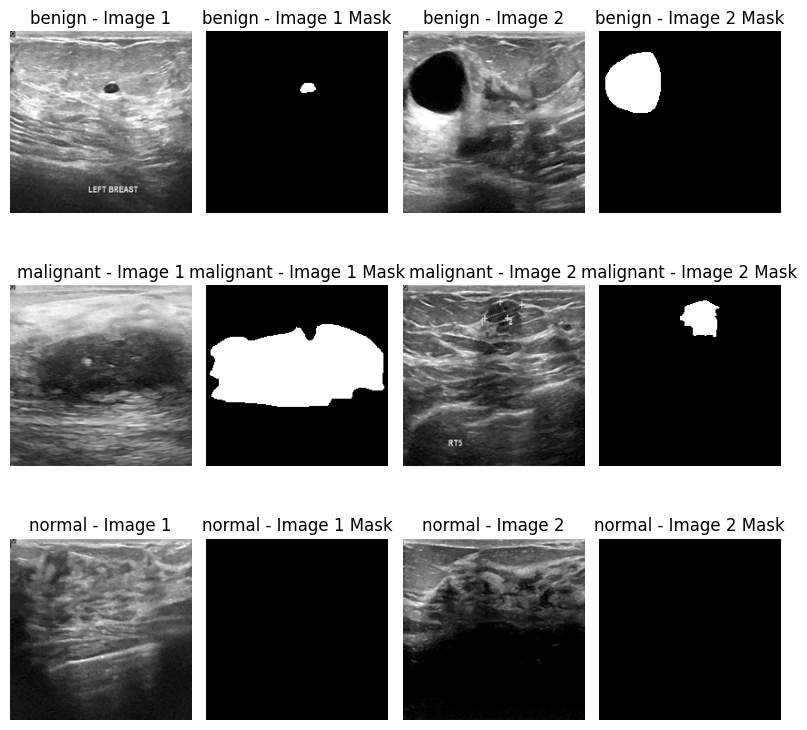

In [ ]:
labels = ['benign', 'malignant', 'normal']
data_dir = '../content/drive/MyDrive/Dataset_BUSI_with_GT'

# Create a figure to display the images
fig, axs = plt.subplots(3, 4, figsize=(8, 8))

desired_width = 200
desired_height = 200

for i, label in enumerate(labels):
    label_dir = os.path.join(data_dir, label)

    # Get a list of image files
    image_files = [file for file in os.listdir(label_dir) if file.endswith('.png')]

    # Sort the list of image files
    image_files = sorted(image_files)

    for j in range(4):
        if j < len(image_files):
            # Load and resize the image
            image_path = os.path.join(label_dir, image_files[j])
            image = Image.open(image_path)
            image = image.resize((desired_width, desired_height), Image.ANTIALIAS)

            if j % 2 == 0:
                image_label = f'{label} - Image {j // 2 + 1}'
            else:
                image_label = f'{label} - Image {j // 2 + 1} Mask'

            axs[i, j].imshow(image)
            axs[i, j].set_title(image_label)
            axs[i, j].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Define the minority classes in your dataset
class_names = ['malignant', 'normal','benign']
minority_classes = ['malignant', 'normal']

# Define custom data transformations for minority classes
minority_class_transforms = transforms.Compose([
    RandomHorizontalFlip(p=0.9),  # Apply with 90% probability
    RandomRotation(15, expand=False, center=None),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
])

# Define data transformations for train, validation, and test sets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        # Apply custom augmentations to minority classes
        transforms.RandomApply([minority_class_transforms], p=0.5) if any(cls in minority_classes for cls in class_names) else transforms.RandomApply([], p=0.0),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def train_model_with_early_stopping(model, lossFunction, optimizer, scheduler, dataloaders, dataset_sizes, class_names, device, num_epochs, patience):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    consecutive_epochs_without_improvement = 0

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = lossFunction(outputs, labels)
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.item())

                # Early stopping: Check if validation loss improved
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    consecutive_epochs_without_improvement = 0
                else:
                    consecutive_epochs_without_improvement += 1

        # Check if early stopping criteria are met
        if consecutive_epochs_without_improvement >= patience:
            print(f"Early stopping after {epoch} epochs")
            break

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:.4f}'.format(best_loss))

    # Load best model weights
    model.load_state_dict(best_model_wts)

    y_true = []
    y_pred = []
    y_scores = []  # For ROC curve

    model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        for inputs, labels in dataloaders['validation']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_scores.extend(torch.softmax(outputs, dim=1).cpu().numpy())

    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    y_true_bin = label_binarize(y_true, classes=range(len(class_names)))

    # Aggregate predictions and compute ROC curve
    fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_scores.ravel())
    roc_auc = auc(fpr, tpr)

    plt.figure()

    plt.plot(fpr, tpr, color='orange', lw=2,
             label='ROC curve (area = {0:0.2f})'.format(roc_auc))

    plt.plot([0, 1], [0, 1], 'k--', lw=2,color="lightgrey")
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])

    plt.gca().set_xlim(left=-0.05)

    plt.xlabel('Specificity')
    plt.ylabel('Sensitivity')
    plt.title('ROC curve')
    plt.legend(loc="lower right")

    # Hide the top and right spines
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.subplots_adjust(left=0.15, right=0.85, top=0.85, bottom=0.15)

    plt.savefig('roc_curve.png', bbox_inches='tight')
    plt.show()

    return model, train_losses, val_losses, train_accuracies, val_accuracies


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=ResourceWarning)

input_dir = '../content/drive/MyDrive/Dataset_BUSI_with_GT'

output_dir = '../content/drive/MyDrive/OverlayedImages'

labels = ['benign', 'malignant', 'normal']
for label in labels:
    os.makedirs(os.path.join(output_dir, label), exist_ok=True)

# Function to overlay images and masks, resize if needed, and save the result
def overlay_and_save(image_path, mask_path, output_path):
    try:
        # Check if both image and mask files exist
        if os.path.exists(image_path) and os.path.exists(mask_path):
            # Open the actual image and mask image
            image = Image.open(image_path)
            mask = Image.open(mask_path)

            # Ensure both images have the same color mode
            if image.mode != mask.mode:
                mask = mask.convert(image.mode)

            # Resize the images if their sizes don't match
            if image.size != mask.size:
                image = image.resize(mask.size)

            # Overlay the image with the mask
            overlayed = Image.blend(image, mask, alpha=0.5)

            # Save the overlayed image to the appropriate label folder
            label = os.path.basename(os.path.dirname(image_path))
            output_path = os.path.join(output_dir, label, os.path.basename(image_path))
            overlayed.save(output_path)
        else:
            #print(f"File not found for: {image_path} or {mask_path}. Skipping...")
            pass
    except Exception as e:
        print(f"An error occurred for: {image_path} or {mask_path}. Error: {str(e)}")

# Iterate through the subdirectories (benign, malignant, normal)
for label in labels:
    label_dir = os.path.join(input_dir, label)
    if os.path.isdir(label_dir):
        for image_filename in os.listdir(label_dir):
            if image_filename.endswith('.png'):
                image_path = os.path.join(label_dir, image_filename)
                # Construct the mask file path based on the naming convention
                mask_filename = image_filename.replace('.png', '_mask.png')
                mask_path = os.path.join(label_dir, mask_filename)
                overlay_and_save(image_path, mask_path, output_dir)

print("Overlayed images have been saved to  directory.")

KeyboardInterrupt: 

In [ ]:
# Function to count the number of files in a directory
def count_files_in_directory(directory):
    return sum(len(files) for _, _, files in os.walk(directory))

# Set the paths to the input and output directories
input_dir = '../content/drive/MyDrive/Dataset_BUSI_with_GT'
output_dir = '../content/drive/MyDrive/OverlayedImages'

# Count the files in the input and output directories
input_counts = {}
output_counts = {}

# Count files in input directory
for label in os.listdir(input_dir):
    label_dir = os.path.join(input_dir, label)
    if os.path.isdir(label_dir):
      input_counts[label] = count_files_in_directory(label_dir)

# Count files in output directory
for label in os.listdir(output_dir):
    label_dir = os.path.join(output_dir, label)
    if os.path.isdir(label_dir):
        output_counts[label] = count_files_in_directory(label_dir)

# Print file counts
print("File Counts Before Overlay-includes masks:")
for label, count in input_counts.items():
    print(f"{label}: {count} files")

print("\nFile Counts After Overlay:")
for label, count in output_counts.items():
    print(f"{label}: {count} files")

File Counts Before Overlay-includes masks:
normal: 266 files
malignant: 421 files
benign: 891 files

File Counts After Overlay:
benign: 437 files
malignant: 210 files
normal: 133 files


<ipython-input-7-a32454aa6680>:24: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize((desired_width, desired_height), Image.ANTIALIAS)


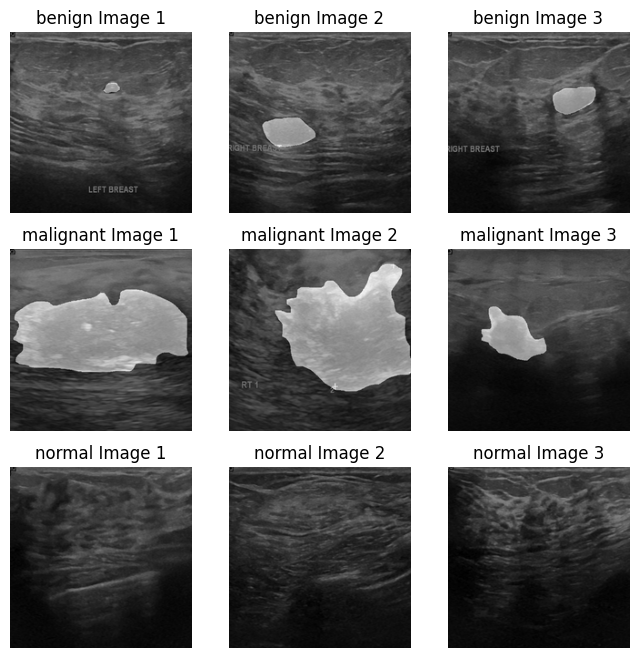

In [ ]:
# Set the path to the overlayed images directory
overlayed_dir =  '../content/drive/MyDrive/OverlayedImages'

# Create subdirectories for each label
labels = ['benign', 'malignant', 'normal']
label_dirs = [os.path.join(overlayed_dir, label) for label in labels]

# Create a figure to display the images
fig, axs = plt.subplots(3, 3, figsize=(8, 8))

desired_width = 200
desired_height = 200

for i, label_dir in enumerate(label_dirs):
    # Get a list of image files and sort them
    images = [image for image in os.listdir(label_dir) if image.endswith('.png')]
    images.sort(key=lambda x: int(x.split('(')[1].split(')')[0]))

    for j, image_filename in enumerate(images[:3]):
        image_path = os.path.join(label_dir, image_filename)
        image = Image.open(image_path)

        # Resize the image to the desired width and height
        image = image.resize((desired_width, desired_height), Image.ANTIALIAS)

        # Display the image in the subplot
        axs[i, j].imshow(image)
        axs[i, j].set_title(f'{labels[i]} Image {j + 1}')
        axs[i, j].axis('off')

plt.show()

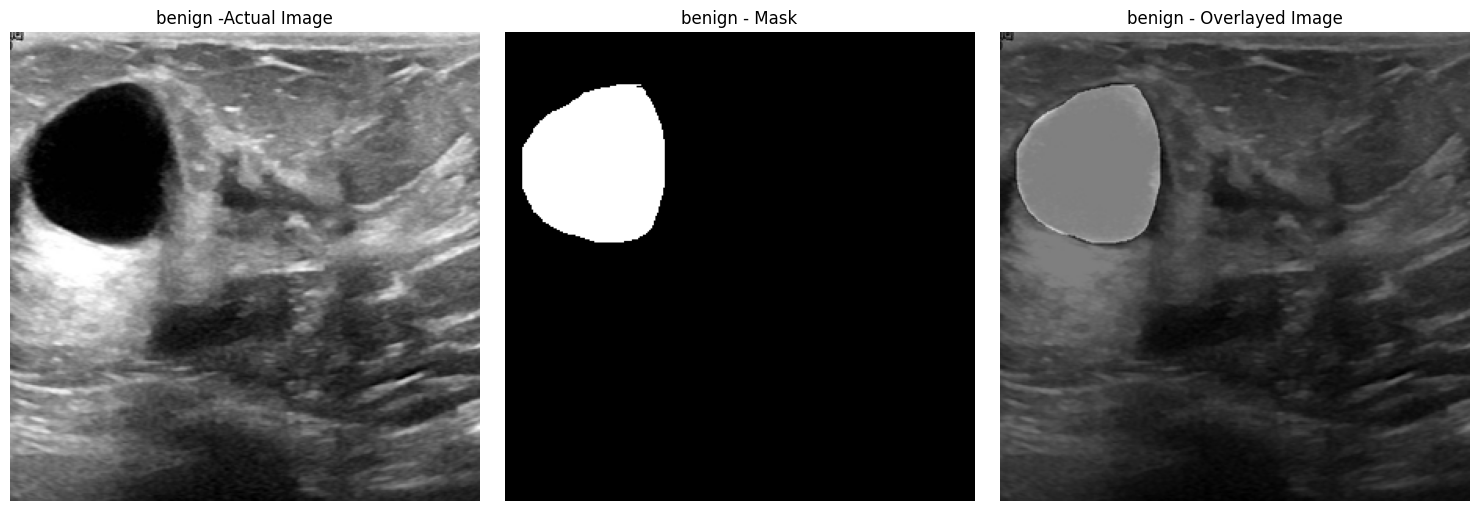

In [ ]:
|input_dir = '../content/drive/MyDrive/Dataset_BUSI_with_GT'
overlayed_dir = '../content/drive/MyDrive/OverlayedImages'

# Create a figure to display the images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Desired width and height for display
desired_width = 300
desired_height = 300

# Select an image
image_filename = 'benign (10).png'

# Construct the file paths
actual_image_path = os.path.join(input_dir, 'benign', image_filename)
mask_image_path = os.path.join(input_dir, 'benign', image_filename.replace(".png", "_mask.png"))
overlayed_image_path = os.path.join(overlayed_dir, 'benign', image_filename)  # Added 'benign' to the path

# Load the images
actual_image = Image.open(actual_image_path)
mask_image = Image.open(mask_image_path)
overlayed_image = Image.open(overlayed_image_path)

# Resize the images
actual_image = actual_image.resize((desired_width, desired_height), Image.ANTIALIAS)
mask_image = mask_image.resize((desired_width, desired_height), Image.ANTIALIAS)
overlayed_image = overlayed_image.resize((desired_width, desired_height), Image.ANTIALIAS)

# Display the images
axs[0].imshow(actual_image)
axs[0].set_title('benign -Actual Image')
axs[0].axis('off')

axs[1].imshow(mask_image, cmap='gray')
axs[1].set_title('benign - Mask')
axs[1].axis('off')

axs[2].imshow(overlayed_image)
axs[2].set_title('benign - Overlayed Image')
axs[2].axis('off')

plt.tight_layout()
plt.show()

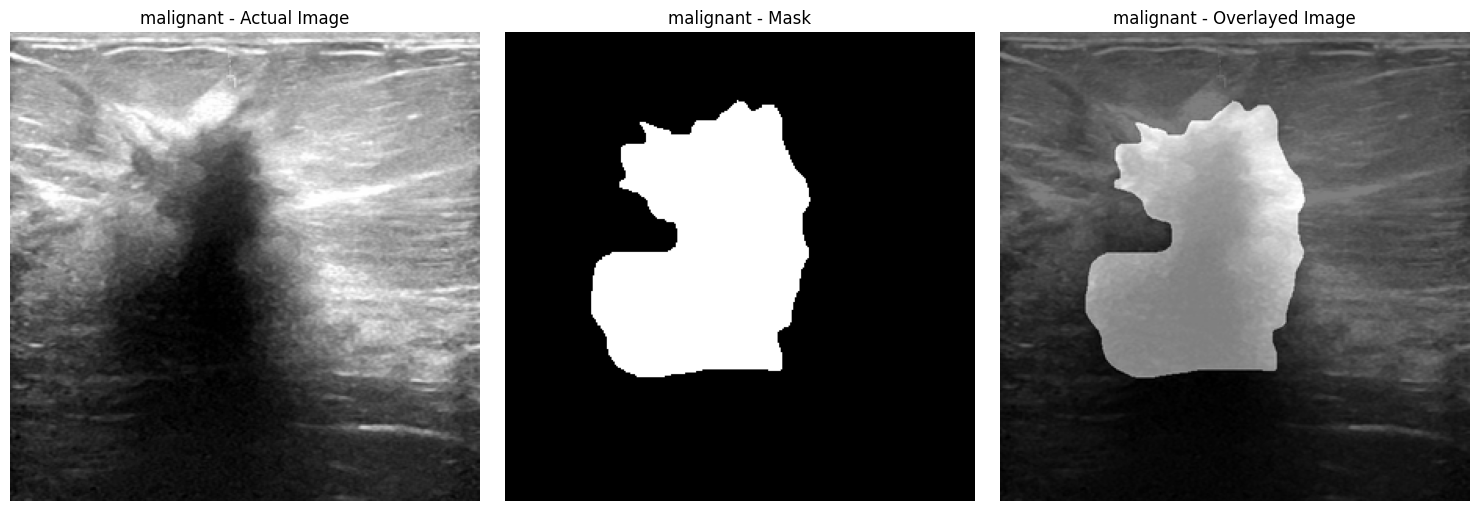

In [ ]:
input_dir = '../content/drive/MyDrive/Dataset_BUSI_with_GT'
overlayed_dir = '../content/drive/MyDrive/OverlayedImages'

# Create a figure to display the images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Desired width and height for display
desired_width = 300
desired_height = 300

# Select an image (change the index as needed)
image_filename = 'malignant (103).png'

# Construct the file paths
actual_image_path = os.path.join(input_dir, 'malignant', image_filename)
mask_image_path = os.path.join(input_dir, 'malignant', image_filename.replace(".png", "_mask.png"))
# Include the 'malignant' subdirectory in the overlayed image path
overlayed_image_path = os.path.join(overlayed_dir, 'malignant', image_filename)

# Load the images
actual_image = Image.open(actual_image_path)
mask_image = Image.open(mask_image_path)
overlayed_image = Image.open(overlayed_image_path)

# Resize the images
actual_image = actual_image.resize((desired_width, desired_height), Image.ANTIALIAS)
mask_image = mask_image.resize((desired_width, desired_height), Image.ANTIALIAS)
overlayed_image = overlayed_image.resize((desired_width, desired_height), Image.ANTIALIAS)

# Display the images
axs[0].imshow(actual_image)
axs[0].set_title('malignant - Actual Image')
axs[0].axis('off')

axs[1].imshow(mask_image, cmap='gray')
axs[1].set_title('malignant - Mask')
axs[1].axis('off')

axs[2].imshow(overlayed_image)
axs[2].set_title('malignant - Overlayed Image')
axs[2].axis('off')

plt.tight_layout()
plt.show()

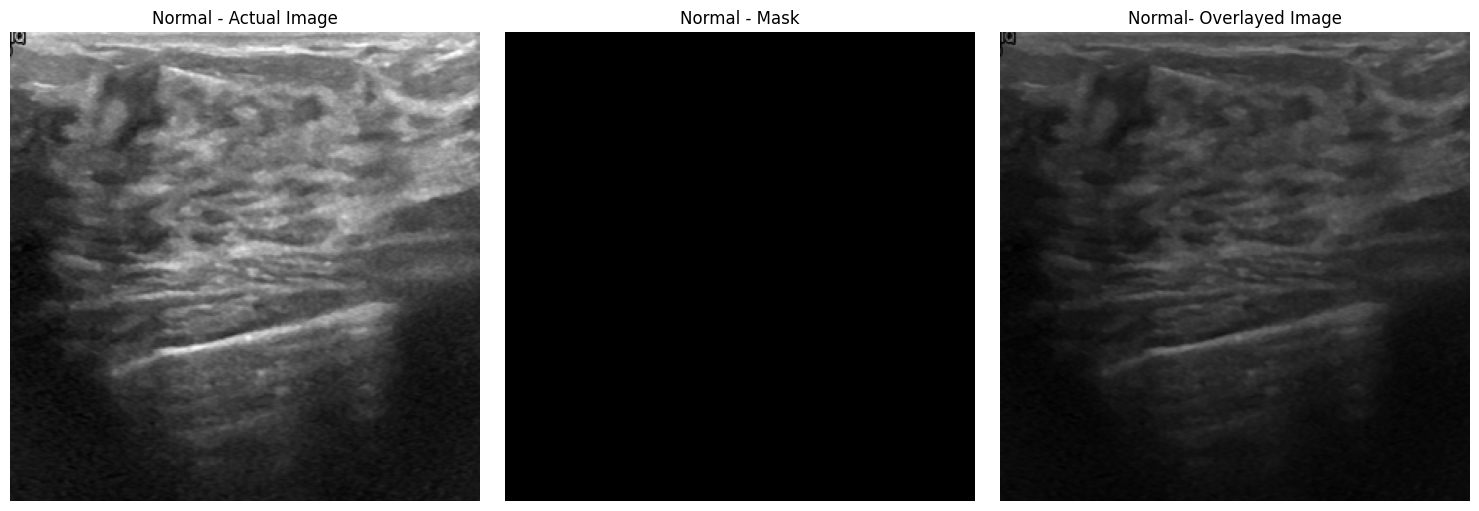

In [ ]:
input_dir = '../content/drive/MyDrive/Dataset_BUSI_with_GT'
overlayed_dir = '../content/drive/MyDrive/OverlayedImages'

# Create a figure to display the images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Desired width and height for display
desired_width = 300
desired_height = 300

# Select an image
image_filename = 'normal (1).png'

# Construct the file paths
actual_image_path = os.path.join(input_dir, 'normal', image_filename)
mask_image_path = os.path.join(input_dir, 'normal', image_filename.replace(".png", "_mask.png"))
# Include the 'normal' subdirectory in the overlayed image path
overlayed_image_path = os.path.join(overlayed_dir, 'normal', image_filename)

# Load the images
actual_image = Image.open(actual_image_path)
mask_image = Image.open(mask_image_path)
overlayed_image = Image.open(overlayed_image_path)

# Resize the images
actual_image = actual_image.resize((desired_width, desired_height), Image.ANTIALIAS)
mask_image = mask_image.resize((desired_width, desired_height), Image.ANTIALIAS)
overlayed_image = overlayed_image.resize((desired_width, desired_height), Image.ANTIALIAS)

# Display the images
axs[0].imshow(actual_image)
axs[0].set_title('Normal - Actual Image')
axs[0].axis('off')

axs[1].imshow(mask_image, cmap='gray')
axs[1].set_title('Normal - Mask')
axs[1].axis('off')

axs[2].imshow(overlayed_image)
axs[2].set_title('Normal- Overlayed Image')
axs[2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Define the minority classes in your dataset
class_names = ['malignant', 'normal','benign']
minority_classes = ['malignant', 'normal']

# Define custom data transformations for minority classes
minority_class_transforms = transforms.Compose([
    RandomHorizontalFlip(p=0.9),  # Apply with 90% probability
    RandomRotation(15, expand=False, center=None),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
])

# Define data transformations for train, validation, and test sets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        # Apply custom augmentations to minority classes
        transforms.RandomApply([minority_class_transforms], p=0.5) if any(cls in minority_classes for cls in class_names) else transforms.RandomApply([], p=0.0),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
# Create a list to store file paths and labels
file_paths = []
labels = []

# Loop through the subdirectories (benign, malignant, normal)
for label in os.listdir(data_dir):
    label_dir = os.path.join(data_dir, label)
    if os.path.isdir(label_dir):
        for image_file in os.listdir(label_dir):
            if image_file.endswith('.png') and not (image_file.endswith('_mask.png') or
                                                     image_file.endswith('_mask_1.png') or
                                                     image_file.endswith('_mask_2.png')):
                image_path = os.path.join(label_dir, image_file)
                labels.append(label)
                file_paths.append(image_path)

# Create a DataFrame to store the file paths and labels
data = pd.DataFrame({'Image_Path': file_paths, 'Label': labels})

# Split the dataset into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.15, random_state=42, stratify=data['Label'])
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42, stratify=train_data['Label'])

# Define the paths for the train, validation, and test directories
train_dir = '/kaggle/working/train'
val_dir = '/kaggle/working/validation'
test_dir = '/kaggle/working/test'

# Create the train, validation, and test directories and subdirectories
for label in labels:
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    os.makedirs(os.path.join(val_dir, label), exist_ok=True)
    os.makedirs(os.path.join(test_dir, label), exist_ok=True)

# Copy the images to the corresponding directories
for _, row in train_data.iterrows():
    image_path = row['Image_Path']
    label = row['Label']
    shutil.copy(image_path, os.path.join(train_dir, label))

for _, row in val_data.iterrows():
    image_path = row['Image_Path']
    label = row['Label']
    shutil.copy(image_path, os.path.join(val_dir, label))

for _, row in test_data.iterrows():
    image_path = row['Image_Path']
    label = row['Label']
    shutil.copy(image_path, os.path.join(test_dir, label))

In [ ]:
import os
train_dir = '/kaggle/working/train'

# List the subdirectories (benign, malignant, normal)
subdirectories = ['benign', 'malignant', 'normal']

# Dictionary to store file counts
file_counts = {}

# Loop through the subdirectories and count files in each
for subdirectory in subdirectories:
    subdirectory_path = os.path.join(train_dir, subdirectory)
    if os.path.exists(subdirectory_path):
        file_count = len(os.listdir(subdirectory_path))
        file_counts[subdirectory] = file_count

# Print the file counts
for category, count in file_counts.items():
   # print("Train folder counts including masks:")
    print(f"Train {category}: {count}")

validation_dir = '/kaggle/working/validation'

# List the subdirectories (benign, malignant, normal)
subdirectories = ['benign', 'malignant', 'normal']

# Dictionary to store file counts
file_counts = {}

# Loop through the subdirectories and count files in each
for subdirectory in subdirectories:
    subdirectory_path = os.path.join(validation_dir, subdirectory)
    if os.path.exists(subdirectory_path):
        file_count = len(os.listdir(subdirectory_path))
        file_counts[subdirectory] = file_count

# Print the file counts
for category, count in file_counts.items():
    #print("Validation folder counts including masks:")
    print(f"Validation {category}: {count}")

test_dir = '/kaggle/working/test'

# List the subdirectories (benign, malignant, normal)
subdirectories = ['benign', 'malignant', 'normal']

# Dictionary to store file counts
file_counts = {}

# Loop through the subdirectories and count files in each
for subdirectory in subdirectories:
    subdirectory_path = os.path.join(test_dir, subdirectory)
    if os.path.exists(subdirectory_path):
        file_count = len(os.listdir(subdirectory_path))
        file_counts[subdirectory] = file_count

# Print the file counts
for category, count in file_counts.items():
    #print("test folder counts including masks:")
    print(f"test {category}: {count}")

Train benign: 315
Train malignant: 152
Train normal: 96
Validation benign: 56
Validation malignant: 27
Validation normal: 17
test benign: 66
test malignant: 31
test normal: 20


In [ ]:
data_dir='/kaggle/working/'

# Create datasets for train, validation, and test
image_datasets = {
    x: ImageFolder(
        root=os.path.join(data_dir, x),
        transform=data_transforms[x]
    )
    for x in ['train', 'validation', 'test']
}

# Specify batch size for dataloaders
batch_size = 32  # You can adjust this based on your hardware and preferences

# Create dataloaders for train, validation, and test
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
               for x in ['train', 'validation', 'test']}

# Calculate dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation', 'test']}

# Get class labels
class_names = image_datasets['train'].classes

# Print dataset sizes and class labels
print("Dataset Sizes:", dataset_sizes)
print("Class Labels:", class_names)

Dataset Sizes: {'train': 563, 'validation': 100, 'test': 117}
Class Labels: ['benign', 'malignant', 'normal']


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
#Transfer Learning by fineTuning the pretrained Resnet50 Model
#Load Resnet50 pretained Model
import torch
import torchvision.models as models
resnet50_model= resnet50(pretrained=True)

print(resnet50)

for param in resnet50_model.parameters():
    param.requires_grad = True

#Get the number of Input features of Resnet last fully connected layer
#because we are going to replace it with new fully connected layer.
in_features = resnet50_model.fc.in_features

#Reset the final fully connected layer of the of the pre-trained Resnet.
resnet50_model.fc = nn.Linear(in_features, len(class_names))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 179MB/s]


<function resnet50 at 0x7b2fbbbadab0>


In [ ]:
import torch
import torchvision.models as models
import torch.nn as nn

# Load AlexNet pretrained model
alexnet_model = models.alexnet(pretrained=True)

# Ensure all layers' parameters require gradient computation
for param in alexnet_model.parameters():
    param.requires_grad = True

# Get the number of input features of AlexNet's last fully connected layer
in_features_alexnet = alexnet_model.classifier[6].in_features

# Replace the final fully connected layer with a new one
alexnet_model.classifier[6] = nn.Linear(in_features_alexnet, len(class_names))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 118MB/s]


In [ ]:
import torch
import torchvision.models as models
import torch.nn as nn

# Load GoogLeNet pretrained model
googlenet_model = models.googlenet(pretrained=True)

# Ensure all layers' parameters require gradient computation
for param in googlenet_model.parameters():
    param.requires_grad = True

# Get the number of input features of GoogLeNet's last fully connected layer
in_features_googlenet = googlenet_model.fc.in_features

# Replace the final fully connected layer with a new one
googlenet_model.fc = nn.Linear(in_features_googlenet, len(class_names))


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 182MB/s]


In [ ]:
import torch
import torchvision.models as models
import torch.nn as nn

# Load VGGNet pretrained model
vggnet_model = models.vgg16(pretrained=True)

# Ensure all layers' parameters require gradient computation
for param in vggnet_model.parameters():
    param.requires_grad = True

# Get the number of input features of VGGNet's last fully connected layer
in_features_vggnet = vggnet_model.classifier[6].in_features

# Replace the final fully connected layer with a new one
vggnet_model.classifier[6] = nn.Linear(in_features_vggnet, len(class_names))


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 120MB/s]


In [ ]:
#Define optimzation algorithm
optimizer_resnet50 = optim.Adam(resnet50_model.parameters(), lr=0.00005)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler_resnet50 = lr_scheduler.StepLR(optimizer_resnet50, step_size=7, gamma=0.1)

#Define Loss Function
loss_function_resnet50 = nn.CrossEntropyLoss()

In [ ]:
# Define optimization algorithm
optimizer_alexnet = optim.Adam(alexnet_model.parameters(), lr=0.00005)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler_alexnet = lr_scheduler.StepLR(optimizer_alexnet, step_size=7, gamma=0.1)

# Define Loss Function
loss_function_alexnet = nn.CrossEntropyLoss()


In [ ]:
# Define optimization algorithm
optimizer_googlenet = optim.Adam(googlenet_model.parameters(), lr=0.00005)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler_googlenet = lr_scheduler.StepLR(optimizer_googlenet, step_size=7, gamma=0.1)

# Define Loss Function
loss_function_googlenet = nn.CrossEntropyLoss()


In [ ]:
# Define optimization algorithm
optimizer_vggnet = optim.Adam(vggnet_model.parameters(), lr=0.00005)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler_vggnet = lr_scheduler.StepLR(optimizer_vggnet, step_size=7, gamma=0.1)

# Define Loss Function
loss_function_vggnet = nn.CrossEntropyLoss()



Epoch 0/49
----------
train Loss: 0.8624 Acc: 0.6163
validation Loss: 0.8321 Acc: 0.5800

Epoch 1/49
----------
train Loss: 0.5484 Acc: 0.7957
validation Loss: 0.5663 Acc: 0.7700

Epoch 2/49
----------
train Loss: 0.3419 Acc: 0.8952
validation Loss: 0.3984 Acc: 0.8600

Epoch 3/49
----------
train Loss: 0.2364 Acc: 0.9147
validation Loss: 0.4221 Acc: 0.8200

Epoch 4/49
----------
train Loss: 0.1901 Acc: 0.9378
validation Loss: 0.3801 Acc: 0.8700

Epoch 5/49
----------
train Loss: 0.1591 Acc: 0.9485
validation Loss: 0.4466 Acc: 0.8500

Epoch 6/49
----------
train Loss: 0.1376 Acc: 0.9503
validation Loss: 0.3901 Acc: 0.8400

Epoch 7/49
----------
train Loss: 0.0950 Acc: 0.9663
validation Loss: 0.3611 Acc: 0.8600

Epoch 8/49
----------
train Loss: 0.0940 Acc: 0.9787
validation Loss: 0.3603 Acc: 0.8700

Epoch 9/49
----------
train Loss: 0.0920 Acc: 0.9716
validation Loss: 0.3644 Acc: 0.8500

Epoch 10/49
----------
validation Loss: 0.3672 Acc: 0.8400

Epoch 11/49
----------
train Loss: 0.085

<ipython-input-9-8e6cb9313fc2>:116: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', lw=2,color="lightgrey")


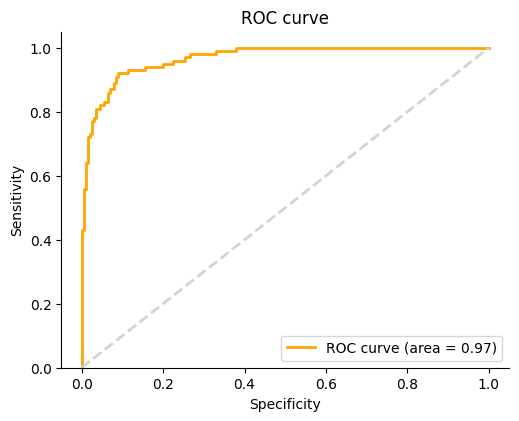

Epoch 0/49
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.9042 Acc: 0.5631
validation Loss: 0.6985 Acc: 0.6300

Epoch 1/49
----------
train Loss: 0.6580 Acc: 0.7194
validation Loss: 0.5087 Acc: 0.8000

Epoch 2/49
----------
train Loss: 0.5301 Acc: 0.7709
validation Loss: 0.4409 Acc: 0.8600

Epoch 3/49
----------
train Loss: 0.4451 Acc: 0.8082
validation Loss: 0.3848 Acc: 0.8500

Epoch 4/49
----------
train Loss: 0.4686 Acc: 0.8082
validation Loss: 0.4499 Acc: 0.8100

Epoch 5/49
----------
train Loss: 0.3785 Acc: 0.8490
validation Loss: 0.4260 Acc: 0.8100

Epoch 6/49
----------
train Loss: 0.3738 Acc: 0.8419
validation Loss: 0.3229 Acc: 0.8800

Epoch 7/49
----------
train Loss: 0.2658 Acc: 0.9059
validation Loss: 0.3025 Acc: 0.8900

Epoch 8/49
----------
train Loss: 0.2775 Acc: 0.8970
validation Loss: 0.2961 Acc: 0.8800

Epoch 9/49
----------
train Loss: 0.2448 Acc: 0.9147
validation Loss: 0.3005 Acc: 0.8800

Epoch 10/49
----------
train Loss: 0.2119 Acc: 0.9343
validation Loss: 0.2998 Acc: 0.9000

Epoch 11/49
----------
train Lo

<ipython-input-9-8e6cb9313fc2>:116: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', lw=2,color="lightgrey")


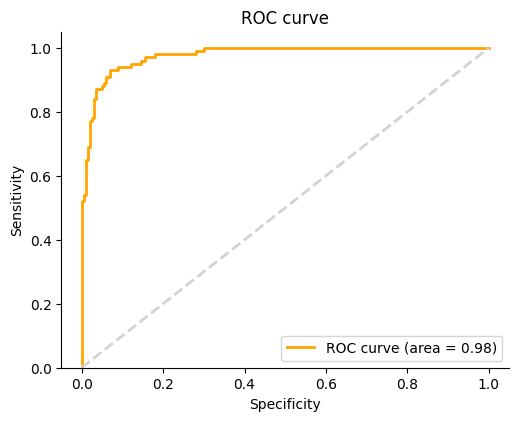

Epoch 0/49
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 1.0433 Acc: 0.4476
validation Loss: 0.9814 Acc: 0.5500

Epoch 1/49
----------
train Loss: 0.8634 Acc: 0.6394
validation Loss: 0.8363 Acc: 0.6400

Epoch 2/49
----------
train Loss: 0.7300 Acc: 0.6998
validation Loss: 0.6933 Acc: 0.6800

Epoch 3/49
----------
train Loss: 0.6229 Acc: 0.7709
validation Loss: 0.5649 Acc: 0.7800

Epoch 4/49
----------
train Loss: 0.5618 Acc: 0.7815
validation Loss: 0.5143 Acc: 0.8100

Epoch 5/49
----------
train Loss: 0.4592 Acc: 0.8472
validation Loss: 0.4695 Acc: 0.8200

Epoch 6/49
----------
train Loss: 0.3904 Acc: 0.8828
validation Loss: 0.4061 Acc: 0.8900

Epoch 7/49
----------
train Loss: 0.3692 Acc: 0.8774
validation Loss: 0.4165 Acc: 0.8700

Epoch 8/49
----------
train Loss: 0.3442 Acc: 0.8952
validation Loss: 0.4079 Acc: 0.8600

Epoch 9/49
----------
train Loss: 0.3243 Acc: 0.8988
validation Loss: 0.4164 Acc: 0.8400

Epoch 10/49
----------
train Loss: 0.3410 Acc: 0.8792
validation Loss: 0.4091 Acc: 0.8400

Epoch 11/49
----------
train Lo

<ipython-input-9-8e6cb9313fc2>:116: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', lw=2,color="lightgrey")


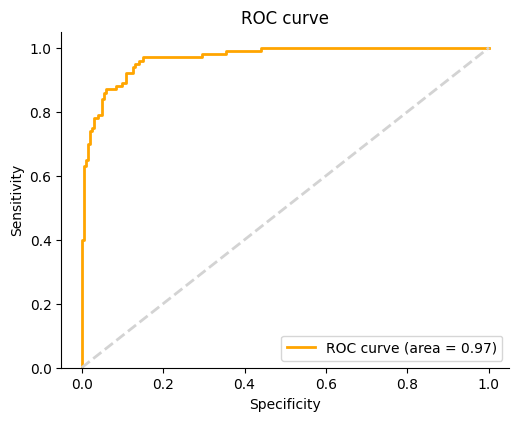

Epoch 0/49
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.0902 Acc: 0.9805
validation Loss: 0.3628 Acc: 0.8600

Epoch 1/49
----------
train Loss: 0.0856 Acc: 0.9734
validation Loss: 0.3629 Acc: 0.8600

Epoch 2/49
----------
train Loss: 0.0948 Acc: 0.9751
validation Loss: 0.3611 Acc: 0.8600

Epoch 3/49
----------
train Loss: 0.0851 Acc: 0.9751
validation Loss: 0.3626 Acc: 0.8600

Epoch 4/49
----------
train Loss: 0.1084 Acc: 0.9645
validation Loss: 0.3627 Acc: 0.8500

Epoch 5/49
----------
train Loss: 0.0877 Acc: 0.9680
validation Loss: 0.3567 Acc: 0.8500

Epoch 6/49
----------
train Loss: 0.0847 Acc: 0.9822
validation Loss: 0.3608 Acc: 0.8700

Epoch 7/49
----------
train Loss: 0.0889 Acc: 0.9751
validation Loss: 0.3620 Acc: 0.8700

Epoch 8/49
----------
train Loss: 0.1008 Acc: 0.9680
validation Loss: 0.3577 Acc: 0.8500

Epoch 9/49
----------
train Loss: 0.1042 Acc: 0.9680
validation Loss: 0.3670 Acc: 0.8500

Epoch 10/49
----------
train Loss: 0.0923 Acc: 0.9716
validation Loss: 0.3659 Acc: 0.8500

Epoch 11/49
----------
train Lo

<ipython-input-9-8e6cb9313fc2>:116: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', lw=2,color="lightgrey")


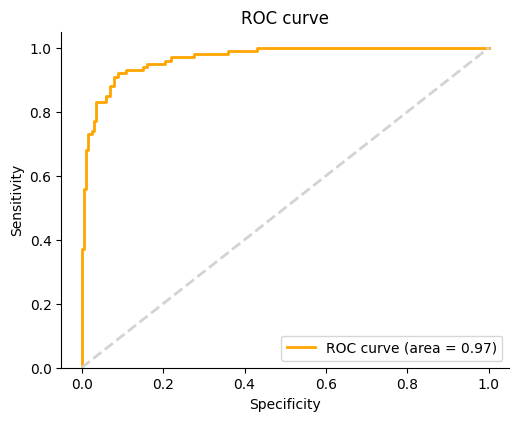

In [ ]:
import multiprocessing as mp

# Use spawn method for multiprocessing
mp.set_start_method('spawn', force=True)

save_dir = r"C:\Academics\AI and Ml"
save_path = os.path.join(save_dir, "resnet50_fineTuning.h5")

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Move the model to the device
resnet50_fineTuning = resnet50_model.to(device)
alexnet_fineTuning = alexnet_model.to(device)
googlenet_fineTuning = googlenet_model.to(device)
vggnet_fineTuning = vggnet_model.to(device)

# Train the model with early stopping
# Example with ResNet
trained_resnet50,train_losses_resnet50, val_losses_resnet_50, train_accuracies_resnet50, val_accuracies_resnet50 = train_model_with_early_stopping(
    resnet50_fineTuning, loss_function_resnet50, optimizer_resnet50, scheduler_resnet50,
    dataloaders, dataset_sizes, class_names, device, num_epochs=50, patience=10
)
# Example with AlexNet
trained_alexnet,train_losses_alexnet,val_losses_alexnet, train_accuracies_alexnet, val_accuracies_alexnet = train_model_with_early_stopping(
    alexnet_fineTuning, loss_function_alexnet, optimizer_alexnet, scheduler_alexnet,
    dataloaders, dataset_sizes, class_names, device, num_epochs=50, patience=10
)

# # Example with GoogLeNet
trained_googlenet,train_losses_googlenet,val_losses_googlenet, train_accuracies_googlenet, val_accuracies_googlenet = train_model_with_early_stopping(
    googlenet_fineTuning, loss_function_googlenet, optimizer_googlenet, scheduler_googlenet,
    dataloaders, dataset_sizes, class_names, device, num_epochs=50, patience=10
)

# # Example with VGGNet
trained_vggnet,train_losses_vggnet,val_losses_vggnet, train_accuracies_vggnet, val_accuracies_vggnet= train_model_with_early_stopping(
    resnet50_fineTuning, loss_function_vggnet, optimizer_vggnet, scheduler_vggnet,
    dataloaders, dataset_sizes, class_names, device, num_epochs=50, patience=10
)


# Save the fine-tuned model
torch.save(trained_resnet50, save_path)
torch.save(trained_alexnet, save_path)
torch.save(trained_googlenet, save_path)
torch.save(trained_vggnet, save_path)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


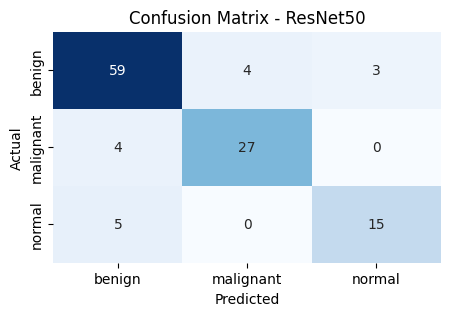

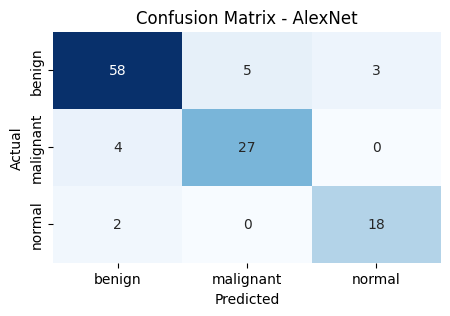

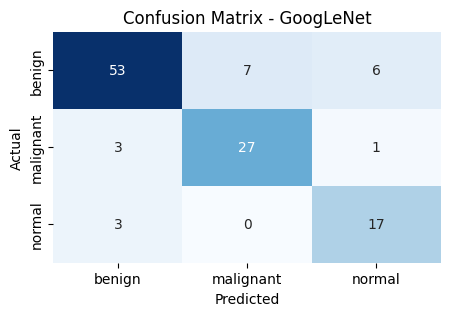

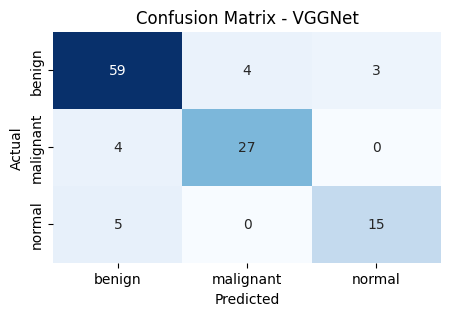


Overall Metrics - ResNet50:
Accuracy: 0.8632
Precision: 0.8573
Recall: 0.8383
F1 Score: 0.8470

Overall Metrics - AlexNet:
Accuracy: 0.8803
Precision: 0.8690
Recall: 0.8833
F1 Score: 0.8758

Overall Metrics - GoogLeNet:
Accuracy: 0.8291
Precision: 0.8003
Recall: 0.8413
F1 Score: 0.8172

Overall Metrics - VGGNet:
Accuracy: 0.8632
Precision: 0.8573
Recall: 0.8383
F1 Score: 0.8470


In [ ]:
!pip install scikit-learn
import sklearn.metrics as metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Define label names
label_names = [str(class_names[i]) for i in range(len(class_names))]

def evaluate_model(model, dataloader, device):
    y_true = []
    y_pred = []

    model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return y_true, y_pred

# Evaluate each model
y_true_resnet, y_pred_resnet = evaluate_model(trained_resnet50, dataloaders['test'], device)
y_true_alexnet, y_pred_alexnet = evaluate_model(trained_alexnet, dataloaders['test'], device)
y_true_googlenet, y_pred_googlenet = evaluate_model(trained_googlenet, dataloaders['test'], device)
y_true_vggnet, y_pred_vggnet = evaluate_model(trained_vggnet, dataloaders['test'], device)

# Generate confusion matrices
confusion_mat_resnet = confusion_matrix(y_true_resnet, y_pred_resnet)
confusion_mat_alexnet = confusion_matrix(y_true_alexnet, y_pred_alexnet)
confusion_mat_googlenet = confusion_matrix(y_true_googlenet, y_pred_googlenet)
confusion_mat_vggnet = confusion_matrix(y_true_vggnet, y_pred_vggnet)

# Plot confusion matrices for each model
def plot_confusion_matrix(confusion_mat, title):
    plt.figure(figsize=(5, 3))
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=label_names, yticklabels=label_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {title}')
    plt.show()

plot_confusion_matrix(confusion_mat_resnet, "ResNet50")
plot_confusion_matrix(confusion_mat_alexnet, "AlexNet")
plot_confusion_matrix(confusion_mat_googlenet, "GoogLeNet")
plot_confusion_matrix(confusion_mat_vggnet, "VGGNet")

# Function to calculate overall metrics
def calculate_overall_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    return accuracy, precision, recall, f1

# Calculate overall metrics for each model
metrics_resnet = calculate_overall_metrics(y_true_resnet, y_pred_resnet)
metrics_alexnet = calculate_overall_metrics(y_true_alexnet, y_pred_alexnet)
metrics_googlenet = calculate_overall_metrics(y_true_googlenet, y_pred_googlenet)
metrics_vggnet = calculate_overall_metrics(y_true_vggnet, y_pred_vggnet)

# Display the overall metrics
def display_overall_metrics(metrics, title):
    print(f"\nOverall Metrics - {title}:")
    print(f"Accuracy: {metrics[0]:.4f}")
    print(f"Precision: {metrics[1]:.4f}")
    print(f"Recall: {metrics[2]:.4f}")
    print(f"F1 Score: {metrics[3]:.4f}")

display_overall_metrics(metrics_resnet, "ResNet50")
display_overall_metrics(metrics_alexnet, "AlexNet")
display_overall_metrics(metrics_googlenet, "GoogLeNet")
display_overall_metrics(metrics_vggnet, "VGGNet")


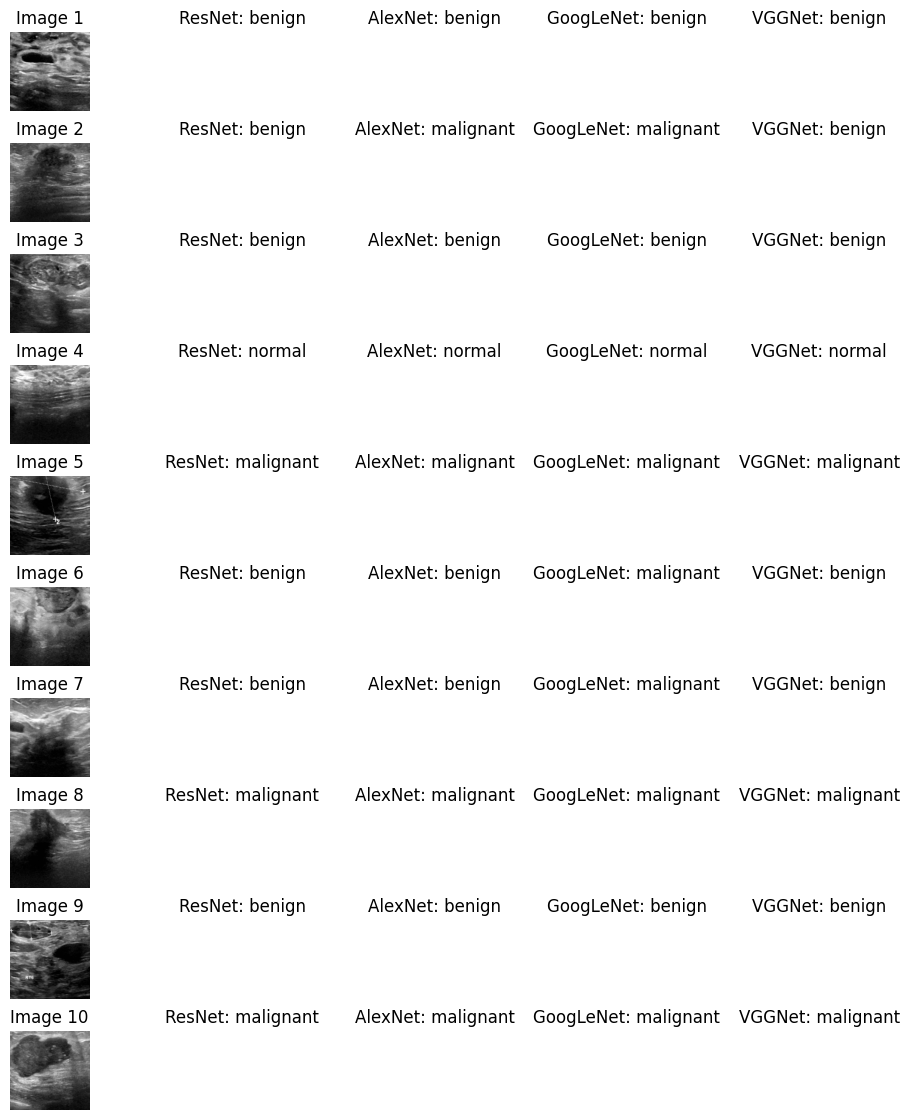

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Set the number of images to display
num_images_to_display = 10

# Create a DataLoader for the test dataset
test_dataloader = DataLoader(image_datasets['test'], batch_size=num_images_to_display, shuffle=True, num_workers=4)

# Get a batch of test data
inputs, labels = next(iter(test_dataloader))

# Move inputs to the device
inputs = inputs.to(device)

# Convert images to grayscale
grayscale_images = inputs.cpu().numpy().mean(axis=1)

# Function to get model predictions
def get_model_predictions(model, inputs):
    with torch.no_grad():
        model.eval()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
    return preds

# Get predictions using each model
preds_resnet = get_model_predictions(trained_resnet50, inputs)
preds_alexnet = get_model_predictions(trained_alexnet, inputs)
preds_googlenet = get_model_predictions(trained_googlenet, inputs)
preds_vggnet = get_model_predictions(trained_vggnet, inputs)

# Plot the grayscale images with labels and predictions for each model
plt.figure(figsize=(12, 14))  # Adjust width to reduce gap

for i in range(num_images_to_display):
    # Plot the original grayscale image
    ax = plt.subplot(num_images_to_display, 5, i * 5 + 1)
    ax.axis('off')
    ax.set_title(f'Image {i+1}')
    plt.imshow(grayscale_images[i], cmap='gray')

    # Plot predictions for each model
    ax = plt.subplot(num_images_to_display, 5, i * 5 + 2)
    ax.axis('off')
    ax.set_title(f'ResNet: {class_names[preds_resnet[i]]}')

    ax = plt.subplot(num_images_to_display, 5, i * 5 + 3)
    ax.axis('off')
    ax.set_title(f'AlexNet: {class_names[preds_alexnet[i]]}')

    ax = plt.subplot(num_images_to_display, 5, i * 5 + 4)
    ax.axis('off')
    ax.set_title(f'GoogLeNet: {class_names[preds_googlenet[i]]}')

    ax = plt.subplot(num_images_to_display, 5, i * 5 + 5)
    ax.axis('off')
    ax.set_title(f'VGGNet: {class_names[preds_vggnet[i]]}')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.2, hspace=0.4)  # wspace controls horizontal space, decrease value to reduce gap

plt.show()
